In [2]:
import sys
print(sys.version)

3.9.18 (main, Sep 11 2023, 08:38:23) 
[Clang 14.0.6 ]


In [3]:
import random
random.seed(36)

In [5]:
import numpy as np
import pandas as pd
import pyarrow as pa
import statsmodels.formula.api as smf
from scipy.stats import boxcox, probplot, norm, gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from QuClu import myfunctions

In [6]:
with pa.memory_map('data/Experiment3_AllFixations_short.arrow', 'r') as source:
    data = pa.ipc.open_file(source).read_all()
    
df = data.to_pandas()
df

distance_to_spaceship  fixation_duration  Dist_to_closest_obstacles  \
0                   6.532785             0.1470                   6.097491   
1                   6.075962             0.6490                   2.892411   
2                   8.698109             0.5380                   3.681632   
3                   6.840493             0.2160                   5.004505   
4                   6.132214             0.3785                   4.208327   
...                      ...                ...                        ...   
27408               2.140648             0.0455                   5.550318   
27409               1.782098             0.0445                   5.788002   
27410               1.654277             0.0290                   6.121837   
27411               1.579990             0.0030                   6.335640   
27412               1.581537             0.0060                   6.500759   

       N_visible_obstacles  input_noise      ID  level trial  \
0                      6.0          0.0  AU25IL    1.0    15   
1                      5.0          0.0  AU25IL    1.0    15   
2                      6.0          0.0  AU25IL    1.0    15   
3                      5.0          0.0  AU25IL    1.0    15   
4                      6.0          0.0  AU25IL    1.0    15   
...                    ...          ...     ...    ...   ...   
27408                  2.0          2.0  IA19EI    6.0    11   
27409                  2.0          2.0  IA19EI    6.0    11   
27410                  2.0          2.0  IA19EI    6.0    11   
27411                  2.0          2.0  IA19EI    6.0    11   
27412                  2.0          2.0  IA19EI    6.0    11   

       distant_fixation cluster  disargeement  
0                   1.0       1           1.0  
1                   1.0       1           1.0  
2                   1.0       1           1.0  
3                   1.0       1           1.0  
4                   1.0       1           1.0  
...                 ...     ...           ...  
27408               0.0       0           1.0  
27409               0.0       0           1.0  
27410               0.0       0           1.0  
27411               0.0       0           1.0  
27412               0.0       0           1.0  

[27413 rows x 11 columns]

In [7]:
df.columns

Index(['distance_to_spaceship', 'fixation_duration',
       'Dist_to_closest_obstacles', 'N_visible_obstacles', 'input_noise', 'ID',
       'level', 'trial', 'distant_fixation', 'cluster', 'disargeement'],
      dtype='object')

# Principal Component Analysis (PCA)

In [8]:
# features of interest
features = ["distance_to_spaceship", "fixation_duration", "Dist_to_closest_obstacles"]

# seperating features
x = df.loc[:, features].values

# define target
y = df.loc[:,['distant_fixation']].values

# standardize features
x = StandardScaler().fit_transform(x)

In [9]:
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['distance_to_spaceship', 'fixation_duration', 'Dist_to_closest_obstacles'])

In [10]:
finalDf = pd.concat([principalDf, df[['distant_fixation']]], axis = 1)

Taking a look at the 2 dimensions other than distance_to_spaceship which clearly drives distant_fixation (whether spaceship is outside of 5° of fixation center point):

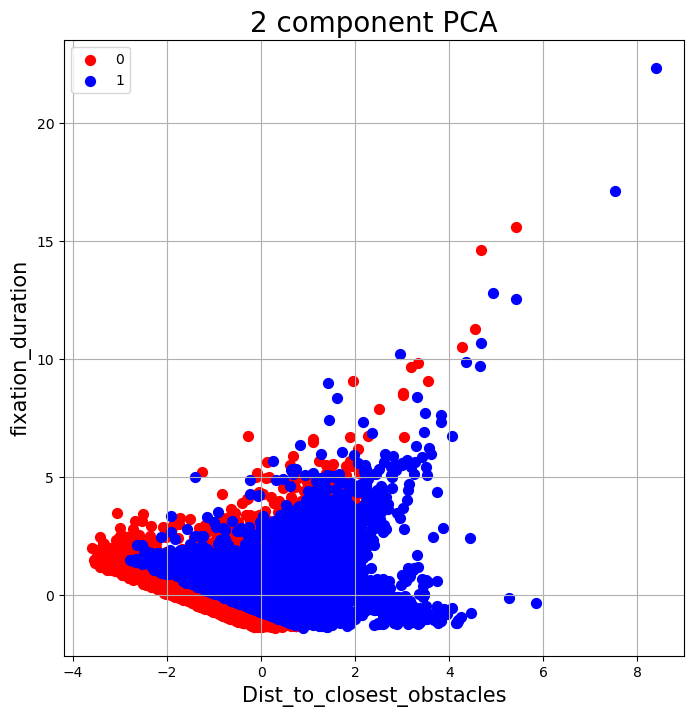

In [11]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Dist_to_closest_obstacles', fontsize = 15)
ax.set_ylabel('fixation_duration', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    target_indices = finalDf['distant_fixation'] == target
    ax.scatter(finalDf.loc[target_indices, 'Dist_to_closest_obstacles'],
               finalDf.loc[target_indices, 'fixation_duration'],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()

Looking at all dimensions simulatenously: (making it interactive to be fancy)

In [51]:
import plotly.express as px

# categorical labels
finalDf['distant_fixation'] = finalDf['distant_fixation'].astype(str)

fig = px.scatter_3d(finalDf,
                    x='distance_to_spaceship',
                    y='fixation_duration',
                    z='Dist_to_closest_obstacles',
                    color='distant_fixation',
                    title='3 component PCA',
                    labels={'distant_fixation': 'Fixation Type'})
fig.show()


Note that the negative values for the distances come from standardizing the features.

In [13]:
pca.explained_variance_ratio_

array([0.39923173, 0.3317225 , 0.26904577])

# Quantile-Based Clustering

### Variable-wise theta_j and Scaled variables through lambda_j

We will assess the silhouette score, as an ~objective metric to choose the optimal number of clusters.

In [14]:
dir(myfunctions)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'alg_CS',
 'alg_CU',
 'alg_VS',
 'alg_VU',
 'fun_CS',
 'fun_CU',
 'fun_VS',
 'fun_VU',
 'math',
 'minimize',
 'np',
 'pd']

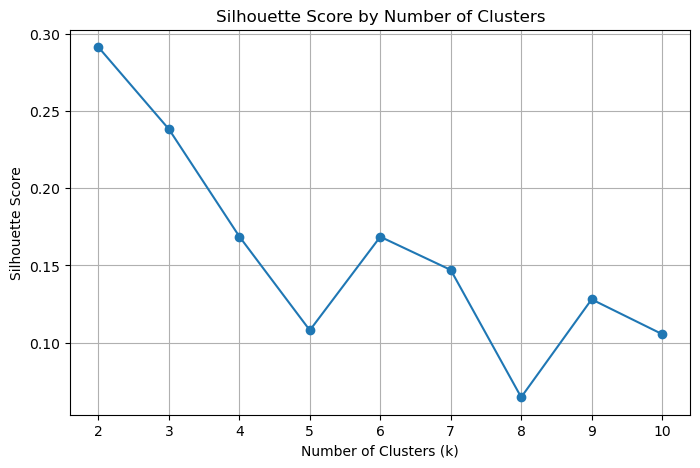

Optimal number of clusters: 2


In [15]:
#from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

features = ["distance_to_spaceship", "fixation_duration", "Dist_to_closest_obstacles"]
X = df[features]

# normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# silhouette score
silhouette_scores = []
K_range = range(2, 11)  # 2-10 clusters

for k in K_range:
    #kmeans = KMeans(n_clusters=k, random_state=42)
    #labels = kmeans.fit_predict(X_scaled)
    cluster = myfunctions.alg_VS(X, k=k, B=50)
    labels = cluster['cl']
    
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# plotting
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Silhouette Score by Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters: {optimal_k}")


In [16]:
# assigning Ncluster to data points and save
features = ["distance_to_spaceship", "fixation_duration", "Dist_to_closest_obstacles"]
X = df[features]

cluster = myfunctions.alg_VS(X, k=2, B=50)
labels = cluster['cl']

df['N_qclu'] = labels

In [17]:
#df.to_csv('data/Experiment3_AllFixations_clustered.csv', index=False)

# Descriptives

In [18]:
from scipy import stats

variables = ["distance_to_spaceship", "fixation_duration", "Dist_to_closest_obstacles"]
clusters = sorted(df["N_qclu"].unique())

summary_list = []

for cluster in clusters:
    cluster_data = df[df["N_qclu"] == cluster]
    for var in variables:
        values = cluster_data[var].dropna()
        
        if len(values) < 2:
            continue  # Skip if not enough data

        mean = values.mean()
        sd = values.std()
        
        # 95% CI using t-distribution
        n = len(values)
        sem = sd / np.sqrt(n)
        ci_low, ci_high = stats.t.interval(0.95, df=n-1, loc=mean, scale=sem)
        
        # Mode using KDE
        kde = stats.gaussian_kde(values)
        x = np.linspace(values.min(), values.max(), 1000)
        y = kde(x)
        mode = x[np.argmax(y)]
        
        summary_list.append({
            "cluster": cluster,
            "variable": var,
            "mean": mean,
            "mode": mode,
            "sd": sd,
            "ci_low": ci_low,
            "ci_high": ci_high
        })

summary_df = pd.DataFrame(summary_list)
pd.set_option("display.precision", 3)
summary_df

cluster                   variable   mean   mode     sd  ci_low  ci_high
0        0      distance_to_spaceship  2.544  1.074  1.489   2.518    2.570
1        0          fixation_duration  0.240  0.021  0.370   0.234    0.247
2        0  Dist_to_closest_obstacles  3.305  2.405  1.920   3.272    3.339
3        1      distance_to_spaceship  8.198  7.826  2.473   8.158    8.238
4        1          fixation_duration  0.178  0.019  0.363   0.172    0.184
5        1  Dist_to_closest_obstacles  4.241  3.435  1.917   4.210    4.272

### Plotting

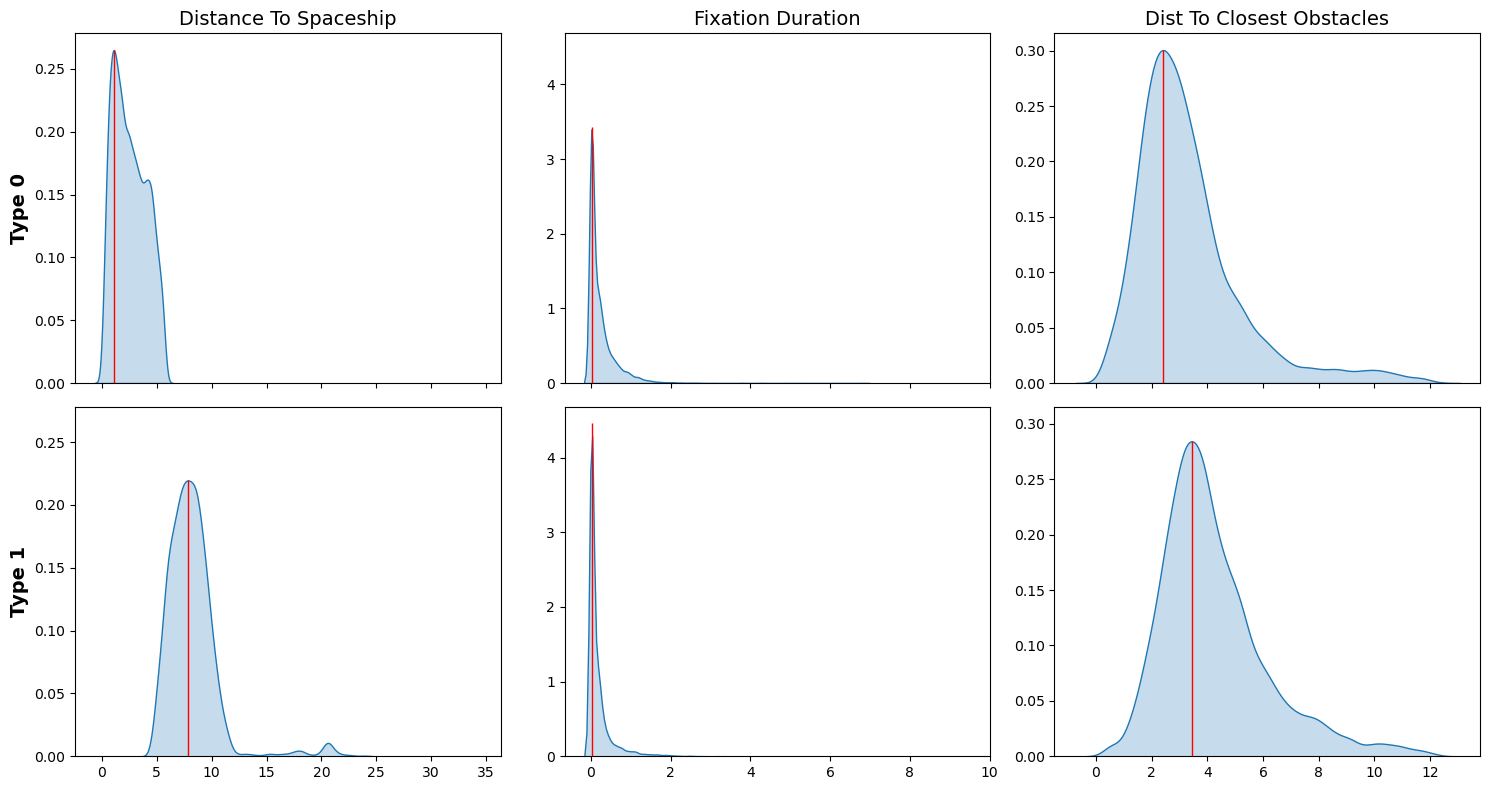

In [19]:
variables = ["distance_to_spaceship", "fixation_duration", "Dist_to_closest_obstacles"]
clusters = sorted(df["N_qclu"].unique())

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharex='col', sharey='col')

for row_idx, cluster in enumerate(clusters):
    cluster_data = df[df["N_qclu"] == cluster]

    for col_idx, var in enumerate(variables):
        ax = axes[row_idx, col_idx]
        values = cluster_data[var].dropna()

        if values.nunique() > 1:
            sns.kdeplot(x=values, ax=ax, fill=True)

            # compute KDE and mode
            kde = gaussian_kde(values)
            x_vals = np.linspace(values.min(), values.max(), 500)
            y_vals = kde(x_vals)
            mode = x_vals[np.argmax(y_vals)]

            # vertical line at mode
            ax.vlines(x=mode, ymin=0, ymax=np.max(y_vals), color='red', linestyle='-', linewidth=1)

        if row_idx == 0:
            ax.set_title(var.replace('_', ' ').title(), fontsize=14)#, fontweight='bold')
        if col_idx == 0:
            ax.set_ylabel(f'Type {cluster}', fontsize=14, fontweight='bold')
        else:
            ax.set_ylabel('')
            
        if row_idx == 1:
            ax.set_xlabel("")  # remove label

plt.tight_layout()
plt.show()

# Clustered Data Analysis

In [20]:
# trial-level info (one row per ID/trial)
trial_info = (
    df[['ID', 'trial', 'level', 'input_noise']]
    .drop_duplicates()
)

# counting fixations per cluster per trial
fixation_counts = (
    df.groupby(['ID', 'trial', 'N_qclu'])
      .size()
      .reset_index(name='n_fixations')
)

# pivot
fixation_counts_pivot = fixation_counts.pivot(
    index=['ID', 'trial'],
    columns='N_qclu',
    values='n_fixations'
)


fixation_counts_pivot.columns = [f'n_fixations_cluster_{col}' for col in fixation_counts_pivot.columns]
fixation_counts_pivot = fixation_counts_pivot.reset_index()

# merge with trial-level info
merged = pd.merge(trial_info, fixation_counts_pivot, on=['ID', 'trial'])

merged = merged.fillna(0).astype({'n_fixations_cluster_0': 'int', 'n_fixations_cluster_1': 'int'})
print(merged.head())


       ID trial  level  input_noise  n_fixations_cluster_0  \
0  AU25IL    15    1.0          0.0                     23   
1  AU25IL    31    1.0          0.5                     41   
2  AU25IL    44    1.0          1.0                     78   
3  AU25IL    34    1.0          1.5                     52   
4  AU25IL    27    1.0          2.0                      6   

   n_fixations_cluster_1  
0                     12  
1                     21  
2                     21  
3                     27  
4                      4  


### Visual inspection of N_fixations during trial

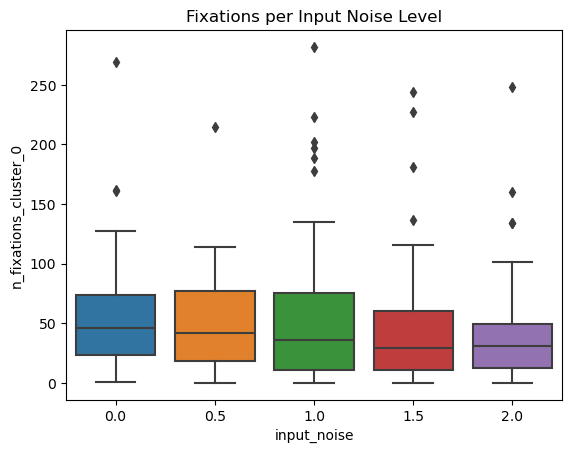

In [21]:
sns.boxplot(data=merged, x='input_noise', y='n_fixations_cluster_0')
plt.title("Fixations per Input Noise Level")
plt.show()

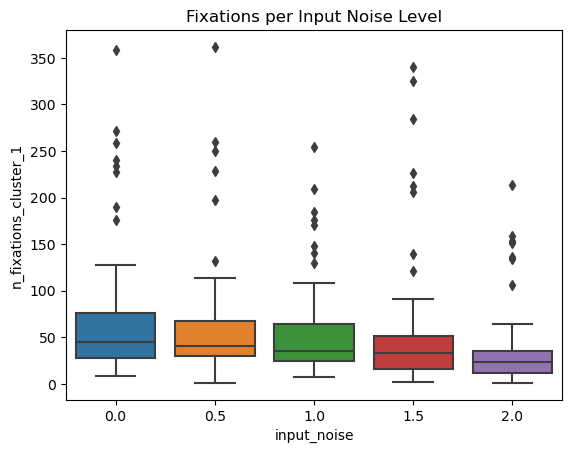

In [22]:
sns.boxplot(data=merged, x='input_noise', y='n_fixations_cluster_1')
plt.title("Fixations per Input Noise Level")
plt.show()

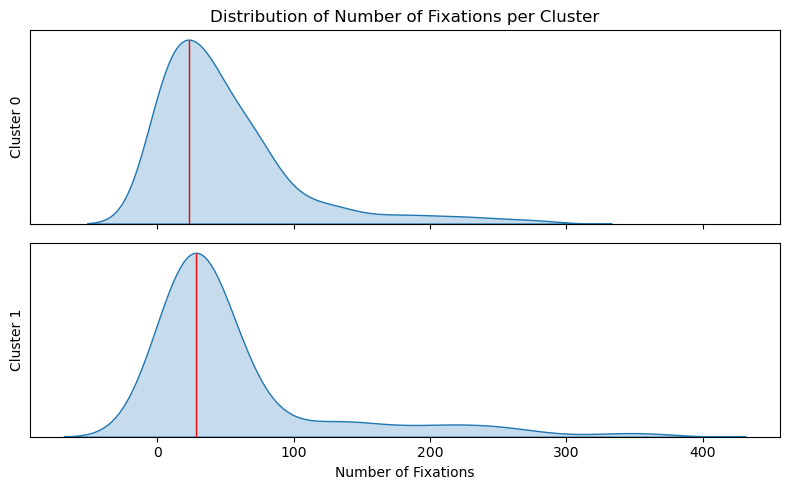

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import numpy as np

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), sharex=True)

for idx, cluster in enumerate([0, 1]):
    col = f"n_fixations_cluster_{cluster}"
    values = merged[col].dropna()

    if values.nunique() > 1:
        sns.kdeplot(x=values, ax=axes[idx], fill=True)

        # Estimate mode with KDE
        kde = gaussian_kde(values)
        x_vals = np.linspace(values.min(), values.max(), 500)
        y_vals = kde(x_vals)
        mode = x_vals[np.argmax(y_vals)]
        ymax = np.max(y_vals)

        # Draw vertical line at mode (ending at top of KDE)
        axes[idx].vlines(mode, ymin=0, ymax=ymax, color='red', linestyle='-', linewidth=1)

    else:
        axes[idx].text(0.5, 0.5, "No variance", transform=axes[idx].transAxes,
                       ha='center', va='center', fontsize=8, color='gray')

    axes[idx].set_ylabel(f"Cluster {cluster}")
    axes[idx].set_yticks([])  # optional: hide y-axis ticks

axes[1].set_xlabel("Number of Fixations")
axes[0].set_title("Distribution of Number of Fixations per Cluster")
plt.tight_layout()
plt.show()


## Combined plot

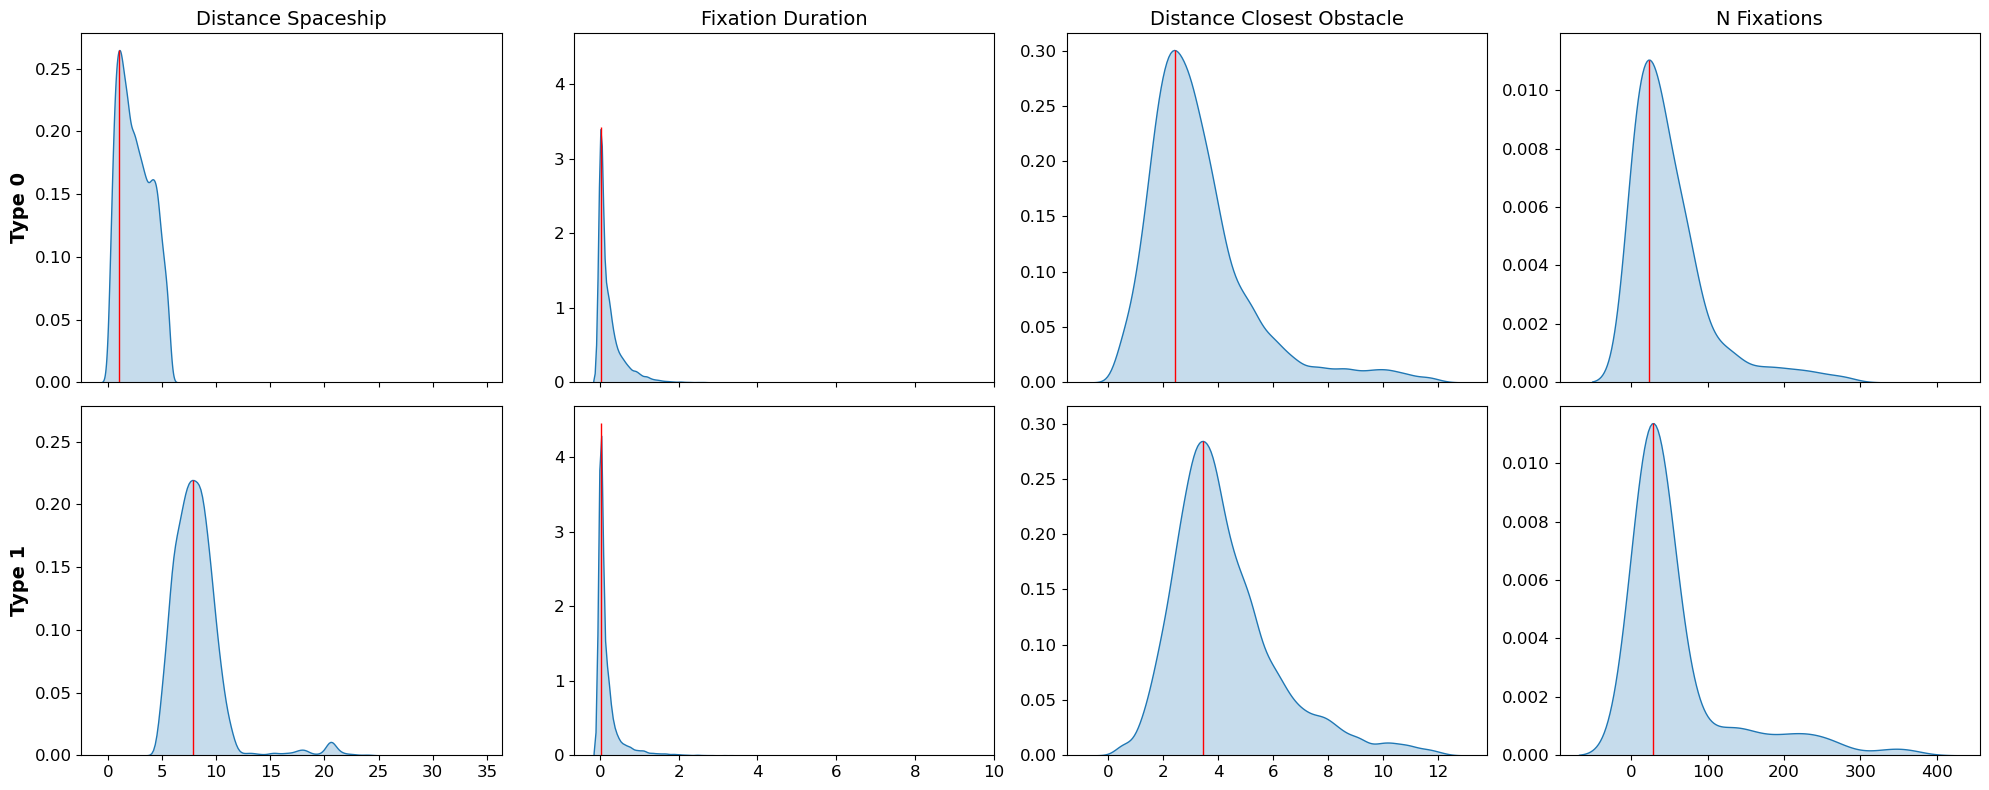

In [78]:
variables = ["distance_to_spaceship", "fixation_duration", "Dist_to_closest_obstacles"]
fixation_columns = {0: "n_fixations_cluster_0", 1: "n_fixations_cluster_1"}
column_titles = ["Distance Spaceship", "Fixation Duration", "Distance Closest Obstacle", "N Fixations"]
clusters = sorted(df["N_qclu"].unique())

fig, axes = plt.subplots(
    nrows=2,
    ncols=4,
    figsize=(20, 8),
    sharex='col',
    sharey='col'
)

for row_idx, cluster in enumerate(clusters):
    data_row = df[df.N_qclu == cluster]

    for col_idx in range(4):
        ax = axes[row_idx, col_idx]

        if col_idx < 3:
            var = variables[col_idx]
            values = data_row[var].dropna()
        else:
            # Fixations column
            var = fixation_columns[cluster]
            values = merged[var].dropna()


        sns.kdeplot(x=values, ax=ax, fill=True)
        kde = gaussian_kde(values)
        x_vals = np.linspace(values.min(), values.max(), 500)
        y_vals = kde(x_vals)
        mode = x_vals[np.argmax(y_vals)]
        ax.vlines(x=mode, ymin=0, ymax=np.max(y_vals), color='red', linestyle='-', linewidth=1)

        # titles only on top row
        if row_idx == 0:
            ax.set_title(column_titles[col_idx], fontsize=14)

        # row label
        if col_idx == 0:
            ax.set_ylabel(f"Type {cluster}", fontsize=14, fontweight='bold')
        else:
            ax.set_ylabel('')

        # hide some stuff
        if col_idx == 3:
            ax.set_ylabel('')
        ax.set_xlabel('')
        
        ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()


## Linear mixed effects modeling

### N fixations

### Type0

In [23]:
_, lmbda = boxcox(merged.n_fixations_cluster_0+1)
lmbda

0.2389906103662924

+1, because values have to be positive

In [24]:
merged['n_fixations_cluster_0_t'] = np.log(merged.n_fixations_cluster_0+1)

In [25]:
model = smf.mixedlm(
    "n_fixations_cluster_0_t ~ input_noise",
    data=merged,
    groups=merged["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:            MixedLM Dependent Variable: n_fixations_cluster_0_t
No. Observations: 254     Method:             ML                     
No. Groups:       6       Scale:              0.8107                 
Min. group size:  35      Log-Likelihood:     -344.5894              
Max. group size:  48      Converged:          Yes                    
Mean group size:  42.3                                               
------------------------------------------------------------------------
               Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
------------------------------------------------------------------------
Intercept       3.550       0.356     9.970    0.000     2.852     4.247
input_noise    -0.181       0.079    -2.304    0.021    -0.335    -0.027
Group Var       0.692       0.463                                       
=====================================================================

"""

### Type1

In [26]:
_, lmbda = boxcox(merged.n_fixations_cluster_1+1)
lmbda

0.041870549744342074

In [27]:
merged['n_fixations_cluster_1_t'] = np.log(merged.n_fixations_cluster_1+1)

In [28]:
model = smf.mixedlm(
    "n_fixations_cluster_1_t ~ input_noise",
    data=merged,
    groups=merged["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:            MixedLM Dependent Variable: n_fixations_cluster_1_t
No. Observations: 254     Method:             ML                     
No. Groups:       6       Scale:              0.6260                 
Min. group size:  35      Log-Likelihood:     -310.6301              
Max. group size:  48      Converged:          Yes                    
Mean group size:  42.3                                               
------------------------------------------------------------------------
               Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
------------------------------------------------------------------------
Intercept       4.059       0.263    15.419    0.000     3.543     4.575
input_noise    -0.415       0.069    -6.001    0.000    -0.550    -0.279
Group Var       0.363       0.279                                       
=====================================================================

"""

## Analyze fixation metrics

In [29]:
df.columns

Index(['distance_to_spaceship', 'fixation_duration',
       'Dist_to_closest_obstacles', 'N_visible_obstacles', 'input_noise', 'ID',
       'level', 'trial', 'distant_fixation', 'cluster', 'disargeement',
       'N_qclu'],
      dtype='object')

In [30]:
type_0 = df[df.N_qclu == 0]
type_1 = df[df.N_qclu == 1]

### Distance to Spaceship

In [31]:
_, lmbda = boxcox(type_0.distance_to_spaceship)
lmbda

0.5390622597074581

In [32]:
type_0['distance_to_spaceship_t'] = np.sqrt(type_0.distance_to_spaceship)

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_1664/1701825223.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
model = smf.mixedlm(
    "distance_to_spaceship_t ~ input_noise",
    data=type_0,
    groups=type_0["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:            MixedLM Dependent Variable: distance_to_spaceship_t
No. Observations: 12725   Method:             ML                     
No. Groups:       6       Scale:              0.2152                 
Min. group size:  207     Log-Likelihood:     -8300.4506             
Max. group size:  4693    Converged:          Yes                    
Mean group size:  2120.8                                             
------------------------------------------------------------------------
               Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
------------------------------------------------------------------------
Intercept       1.575       0.088    17.859    0.000     1.402     1.748
input_noise    -0.023       0.006    -4.003    0.000    -0.035    -0.012
Group Var       0.046       0.058                                       
=====================================================================

"""

In [34]:
_, lmbda = boxcox(type_1.distance_to_spaceship)
lmbda

-0.9086799379070635

In [35]:
type_1['distance_to_spaceship_t'] = 1/type_1.distance_to_spaceship

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_1664/1722555321.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
model = smf.mixedlm(
    "distance_to_spaceship_t ~ input_noise",
    data=type_1,
    groups=type_1["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:            MixedLM Dependent Variable: distance_to_spaceship_t
No. Observations: 14688   Method:             ML                     
No. Groups:       6       Scale:              0.0009                 
Min. group size:  882     Log-Likelihood:     30999.7076             
Max. group size:  5715    Converged:          Yes                    
Mean group size:  2448.0                                             
------------------------------------------------------------------------
               Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
------------------------------------------------------------------------
Intercept       0.130       0.003    43.764    0.000     0.125     0.136
input_noise    -0.000       0.000    -1.155    0.248    -0.001     0.000
Group Var       0.000       0.001                                       
=====================================================================

"""

### Fixation duration

In [37]:
_, lmbda = boxcox(type_0.fixation_duration)
lmbda

0.09330689750022651

In [38]:
type_0['fixation_duration_t'] = np.log(type_0.fixation_duration)

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_1664/331492430.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
model = smf.mixedlm(
    "fixation_duration_t ~ input_noise",
    data=type_0,
    groups=type_0["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:            MixedLM Dependent Variable: fixation_duration_t
No. Observations: 12725   Method:             ML                 
No. Groups:       6       Scale:              1.9956             
Min. group size:  207     Log-Likelihood:     -22474.5155        
Max. group size:  4693    Converged:          Yes                
Mean group size:  2120.8                                         
-------------------------------------------------------------------
               Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-------------------------------------------------------------------
Intercept      -2.069      0.604   -3.425   0.001   -3.253   -0.885
input_noise    -0.097      0.018   -5.519   0.000   -0.132   -0.063
Group Var       2.185      0.888                                   
=================================================================

"""

In [40]:
_, lmbda = boxcox(type_1.fixation_duration)
lmbda

-0.016524778919011465

In [41]:
type_1['fixation_duration_t'] = np.log(type_1.fixation_duration)

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_1664/3574830597.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [42]:
model = smf.mixedlm(
    "fixation_duration_t ~ input_noise",
    data=type_1,
    groups=type_1["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:            MixedLM Dependent Variable: fixation_duration_t
No. Observations: 14688   Method:             ML                 
No. Groups:       6       Scale:              1.9566             
Min. group size:  882     Log-Likelihood:     -25793.6392        
Max. group size:  5715    Converged:          Yes                
Mean group size:  2448.0                                         
-------------------------------------------------------------------
               Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-------------------------------------------------------------------
Intercept      -2.452      0.584   -4.202   0.000   -3.596   -1.308
input_noise     0.043      0.016    2.618   0.009    0.011    0.075
Group Var       2.041      0.842                                   
=================================================================

"""

### Distance to closest obstacle

In [43]:
_, lmbda = boxcox(type_0.Dist_to_closest_obstacles)
lmbda

0.16259884377933723

In [44]:
type_0['Dist_to_closest_obstacles_t'] = np.log(type_0.Dist_to_closest_obstacles)

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_1664/642020871.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
model = smf.mixedlm(
    "Dist_to_closest_obstacles_t ~ input_noise",
    data=type_0,
    groups=type_0["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:            MixedLM Dependent Variable: Dist_to_closest_obstacles_t
No. Observations: 12725   Method:             ML                         
No. Groups:       6       Scale:              0.3114                     
Min. group size:  207     Log-Likelihood:     -10644.3332                
Max. group size:  4693    Converged:          Yes                        
Mean group size:  2120.8                                                 
----------------------------------------------------------------------------
                   Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
----------------------------------------------------------------------------
Intercept           1.036       0.041    25.382    0.000     0.956     1.116
input_noise        -0.000       0.007    -0.023    0.981    -0.014     0.013
Group Var           0.009       0.010                                       
=========================================================================

"""

In [46]:
_, lmbda = boxcox(type_1.Dist_to_closest_obstacles)
lmbda

0.24595936337495694

In [47]:
type_1['Dist_to_closest_obstacles_t'] = np.log(type_1.Dist_to_closest_obstacles)

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_1664/2089663632.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
model = smf.mixedlm(
    "Dist_to_closest_obstacles_t ~ input_noise",
    data=type_1,
    groups=type_1["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:            MixedLM Dependent Variable: Dist_to_closest_obstacles_t
No. Observations: 14688   Method:             ML                         
No. Groups:       6       Scale:              0.2051                     
Min. group size:  882     Log-Likelihood:     -9218.8604                 
Max. group size:  5715    Converged:          Yes                        
Mean group size:  2448.0                                                 
-----------------------------------------------------------------------------
                Coef.     Std.Err.       z        P>|z|     [0.025     0.975]
-----------------------------------------------------------------------------
Intercept       1.327        0.029     45.585     0.000      1.270      1.384
input_noise     0.034        0.005      6.356     0.000      0.023      0.044
Group Var       0.005        0.006                                           
=========================================================================

"""